# Orthogonal Bernoulli polynomials, scaled by BSS-ANOVA kernel

Importing packages.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

Defining the BSS-ANOVA kernel main effect $\kappa_1$, outlined in equation 8 of [Fast variable selection makes Karhunen-Loève decomposed Gaussian process BSS-ANOVA a speedy and accurate choice for dynamic systems identification](docs/_static/arXiv.2205.13676v2.pdf),

$\kappa_1(x,x') = \mathcal{B}(x)\mathcal{B}_1(x') + \mathcal{B}_2(x)\mathcal{B}_2(x') + \frac{1}{24}\mathcal{B}_4(|x-x'|)$

where

$\begin{cases} \mathcal{B}_1(x) = x - \frac{1}{2} \\ \mathcal{B}_2(x) = x^2 - x + \frac{1}{6} \\ \mathcal{B}_4(x) = x^4 - 2x^3 + x^2 - \frac{1}{30} \end{cases}$

In [5]:
def b1(x):
    return x - 1/2

def b2(x):
    return x**2 - x + 1/6

def b4(x):
    return x**4 - 2*x**3 + x**2 - 1/30

def k1(xi, xj):
    return b1(xi)*b1(xj) + b2(xi)*b2(xj) - b4(np.abs(xi-xj))/24

Taking eigenvalues for increasing resolution of covariance matrix (i.e., BSS-ANOVA kernel). Because only 20 Bernoulli polynomials could be computed in MATLAB prior to Inf, only need first 20 eigenvalues.

In [22]:
n = 20  # number of Bernoulli polynomials defined numerically prior to Inf
res_n = 5  # number of points to plot
res_lb = 1600  # lower bound (of plot)
res_ub = 2000  # upper bound (of plot)

eigvals = np.zeros([res_n, n])
res_x = np.linspace(res_lb, res_lb + np.round((res_ub-res_lb)/(res_n-1))*(res_n-1), res_n, dtype=int)
res_iter = 0
for res in res_x:
    x = np.linspace(0, 1, res)
    kernel = np.zeros([res, res])

    for i in range(res):
        for j in range(res):
            kernel[i, j] = k1(x[i], x[j])
    eigval, eigvec = np.linalg.eig(kernel)

    eigvals[res_iter, :] = eigval[:n]  # in future, plot columns which are basis function scales
    res_iter += 1

progress = np.concatenate([res_x[:, np.newaxis], eigvals], axis=1)
np.savetxt(f'current_progress_{res_lb}_{res_ub}.txt', progress)  # res points by basis function order (i.e., 'k' or eigenvalue id)

/tmp/ipykernel_28833/3318184751.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  eigvals[res_iter, :] = eigval[:n]  # in future, plot columns which are basis function scales


Re-generating BSS-ANOVA kernel as is in FoKL (i.e., 500x500).

In [7]:
bss_anova = np.zeros([500, 500])
for i in range(500):
    for j in range(500):
        bss_anova[i, j] = k1(x[i], x[j])
eigval, eigvec =  np.linalg.eig(bss_anova)
eigvec_scaled = np.zeros_like(eigvec)
for i in range(500):
    eigvec_scaled[:, i] = np.sqrt(eigval[i]) * eigvec[:, i]  # scale eigenvector by sqrt(eigenvalue)
spline = CubicSpline(x, eigvec_scaled)
bases = spline(x)

Fitting asymptotes using exponential approximation $c_1 + c_2 x^{-1}$, and plotting.

In [8]:
def fit_func(x, c1, c2):
    return c1 + c2/x

popts = []
for k in range(res_n):
    popt, pcov = curve_fit(fit_func, res_x, eigvals[:, k], [0, 1])
    popts.append(popt)

Plotting eigenvalues and asymptote:

IndexError: list index out of range

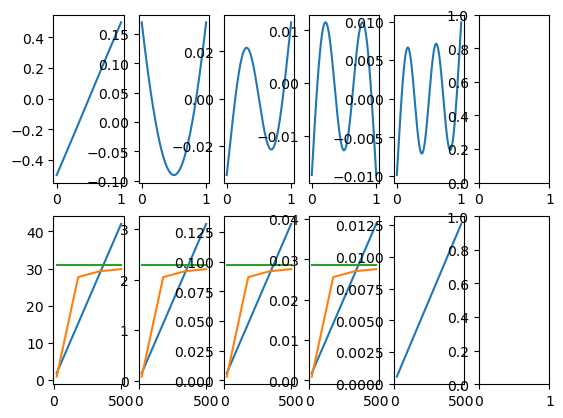

In [11]:
fig, axs = plt.subplots(2, 6)
for k in range(6):
    axs[0, k].plot(x, bases[:, k])

    axs[1, k].plot(res_x, eigvals[:, k])  # eigenvalues at different kernel resolutions
    axs[1, k].plot(res_x, fit_func(res_x, *popts[k]))  # fitted curve
    axs[1, k].plot([res_lb, res_ub], [popts[k][0], popts[k][0]])  # asymptote
    

Plotting BSS-ANOVA vs. asymptote-scaled Bernoulli:

In [ ]:
plt.subplot([2, 6])
for i in range(6):
    plt.subplot([0, i], bss_anova[i])


    plt.subplot([1, i], scale[i] * bernoulli[i])